In [1]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
SAMPLE_RATE = 22050
SEGMENT_DURATION = 5  # in seconds
N_MFCC = 20
ACCEPTED_FORMATS = ["wav", "WAV"]

In [3]:
def get_data(data_path):
    data = {"mappings": [], "images": [], "labels": []}

    segment_length = SAMPLE_RATE * SEGMENT_DURATION

    for label_index, label_name in enumerate(os.listdir(data_path)):
        label_path = os.path.join(data_path, label_name)

        if os.path.isdir(label_path) is not True:
            continue

        print(f"[+] Currently processing {label_name} label")

        for audio_name in os.listdir(label_path):
            audio_path = os.path.join(label_path, audio_name)

            if audio_name.split(".")[-1] not in ACCEPTED_FORMATS:
                continue

            try:
                audio, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
            except Exception as e:
                print(f"\t[-] Audio {audio_path} is invalid!")

            no_segements_in_audio = len(audio) // segment_length
            mfcc_list = []

            for segment_count in range(no_segements_in_audio):
                start = segment_count * segment_length
                end = start + segment_length

                audio_segment = audio[start:end]

                mfcc = librosa.feature.mfcc(
                    y=audio_segment, sr=SAMPLE_RATE, n_mfcc=N_MFCC
                )

                mfcc_list.append(mfcc.tolist())

            data["images"].extend(mfcc_list)
            data["labels"].extend([label_index] * len(mfcc_list))

    return data

In [70]:
def get_train_test_sequential_data(
    data, train_size=0.8, normalize=True, return_ss_instance=True
):

    images = np.array(data["images"], dtype=np.float16)

    labels = np.array(data["labels"], dtype=np.float16)


    train_images = []
    test_images = []
    train_labels = []
    test_labels = []

    for label_name, label_count in zip(*np.unique(labels, return_counts=True)):
        positions = np.where(labels == label_name)[0]
        split_index = int(label_count * train_size)

        train_positions = positions[:split_index]
        test_positions = positions[split_index:]

        train_images.extend(images[train_positions].tolist())
        test_images.extend(images[test_positions].tolist())

        train_labels.extend(labels[train_positions].tolist())
        test_labels.extend(labels[test_positions].tolist())

    train_images = np.array(train_images, dtype=np.float16)
    test_images = np.array(test_images, dtype=np.float16)
    train_labels = np.array(train_labels, dtype=np.float16)
    test_labels = np.array(test_labels, dtype=np.float16)


    train_images_shape = train_images.shape

    test_images_shape = test_images.shape


    if normalize is True:

        ss = StandardScaler()

        train_images = ss.fit_transform(

            train_images.reshape(

                train_images_shape[0], train_images_shape[1] * train_images_shape[2]
            )
        )

        test_images = ss.transform(

            test_images.reshape(

                test_images_shape[0], test_images_shape[1] * test_images_shape[2]
            )
        )


        train_images = train_images.reshape(train_images_shape)

        test_images = test_images.reshape(test_images_shape)


    if return_ss_instance is True:
        return (train_images, test_images, train_labels, test_labels, ss)

    return (train_images, test_images, train_labels, test_labels)

In [51]:
def get_train_test_with_random_shuffle(data, train_size=0.8, normalize=True):
    images = np.array(data["images"], dtype=np.float16)
    labels = np.array(data["labels"], dtype=np.float16)

    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, train_size=train_size, stratify=labels, shuffle=True
    )

    train_images_shape = train_images.shape
    test_images_shape = test_images.shape

    if normalize is True:
        ss = StandardScaler()
        train_images = ss.fit_transform(
            train_images.reshape(
                train_images_shape[0], train_images_shape[1] * train_images_shape[2]
            )
        )
        test_images = ss.transform(
            test_images.reshape(
                test_images_shape[0], test_images_shape[1] * test_images_shape[2]
            )
        )

        train_images = train_images.reshape(train_images_shape)
        test_images = test_images.reshape(test_images_shape)

    return (train_images, test_images, train_labels, test_labels)

Example using GTZAN Dataset


In [52]:
data = get_data(
    r"C:\Users\zuraj\OneDrive\Desktop\Audio Processing\Data\GTZAN Dataset(Music Genre Classification)\Data\genres_original"
)

In [53]:
X_train, X_test, y_train, y_test, ss = get_train_test_sequential_data(data)

In [54]:
X_train.shape

(4791, 20, 216)

In [55]:
X_test.shape

(1200, 20, 216)

In [56]:
y_test.shape

(1200,)

In [57]:
y_train.shape

(4791,)

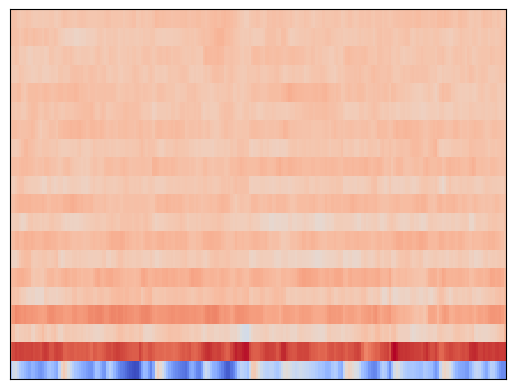

In [67]:
librosa.display.specshow(np.array(data["images"][1]))

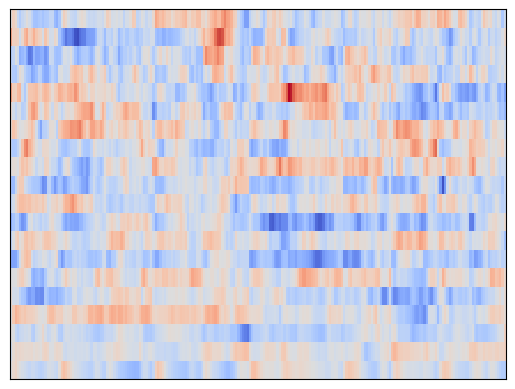

In [69]:
librosa.display.specshow(
    ss.transform(np.array(data["images"][1]).reshape(1, 4320)).reshape(20, 216)
)